In [3]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

## Initialize

In [96]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
figure_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_figures'

subjects_to_process = ['04']

period = 'pre'

In [97]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]


downfreq = 128

In [98]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)

    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_error_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    events_sv = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


    

IndexError: list index out of range

In [ ]:
#making raw object from .mat data

info_raw = mne.create_info(ch_names=ch_names_64, sfreq = 128, ch_types='eeg')
raw = mne.io.RawArray(eeg, info = info_raw)
raw.set_montage('biosemi64')


Creating RawArray with float64 data, n_channels=64, n_times=56320
    Range : 0 ... 56319 =      0.000 ...   439.992 secs
Ready.


<RawArray | 64 x 56320 (440.0 s), ~27.6 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


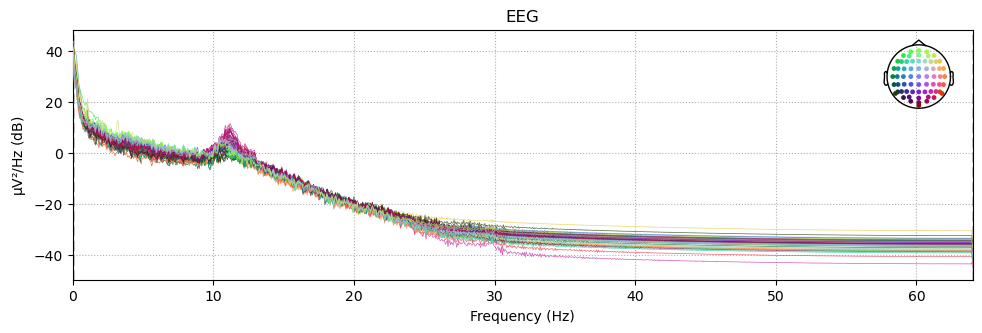

In [ ]:
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

## ICA

In [ ]:
ica = ICA(max_iter="auto", random_state=97)
ica.fit(raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76540/3142827221.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 7.4s.


Method,fastica
Fit,137 iterations on raw data (56320 samples)
ICA components,64
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


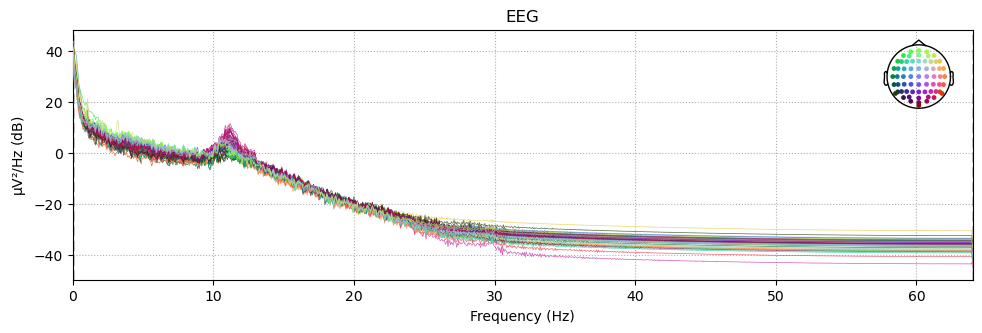

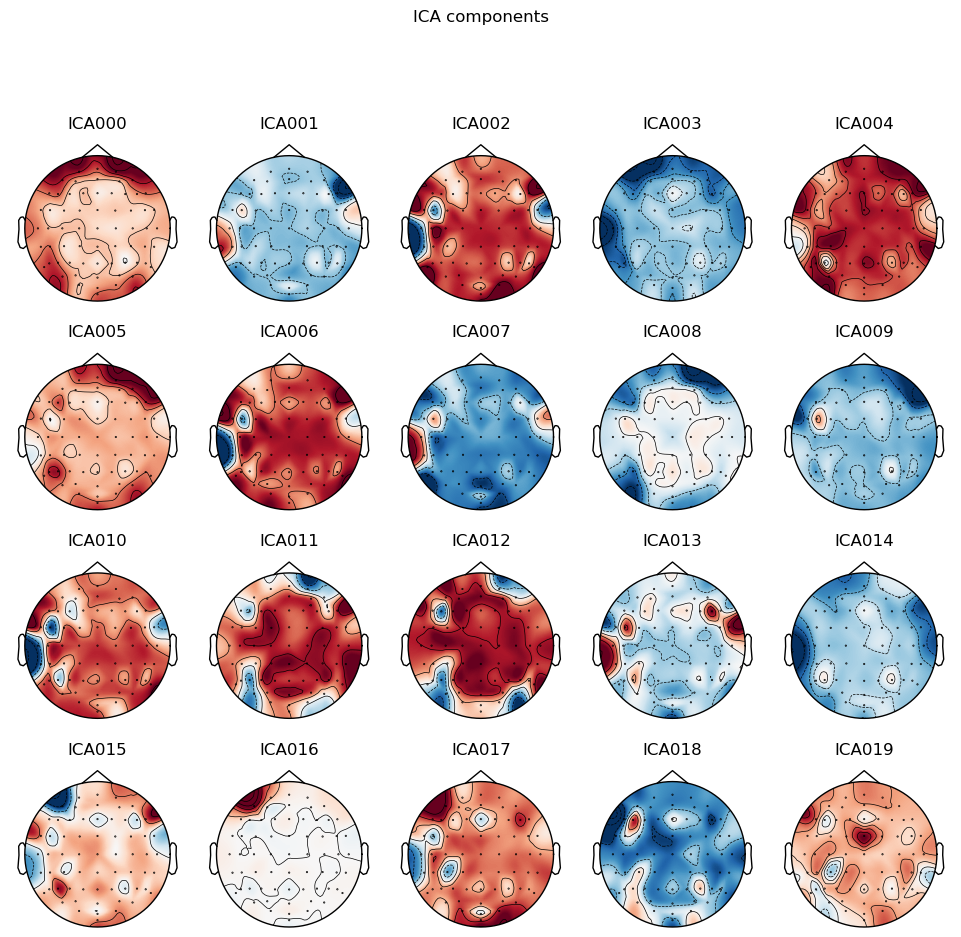

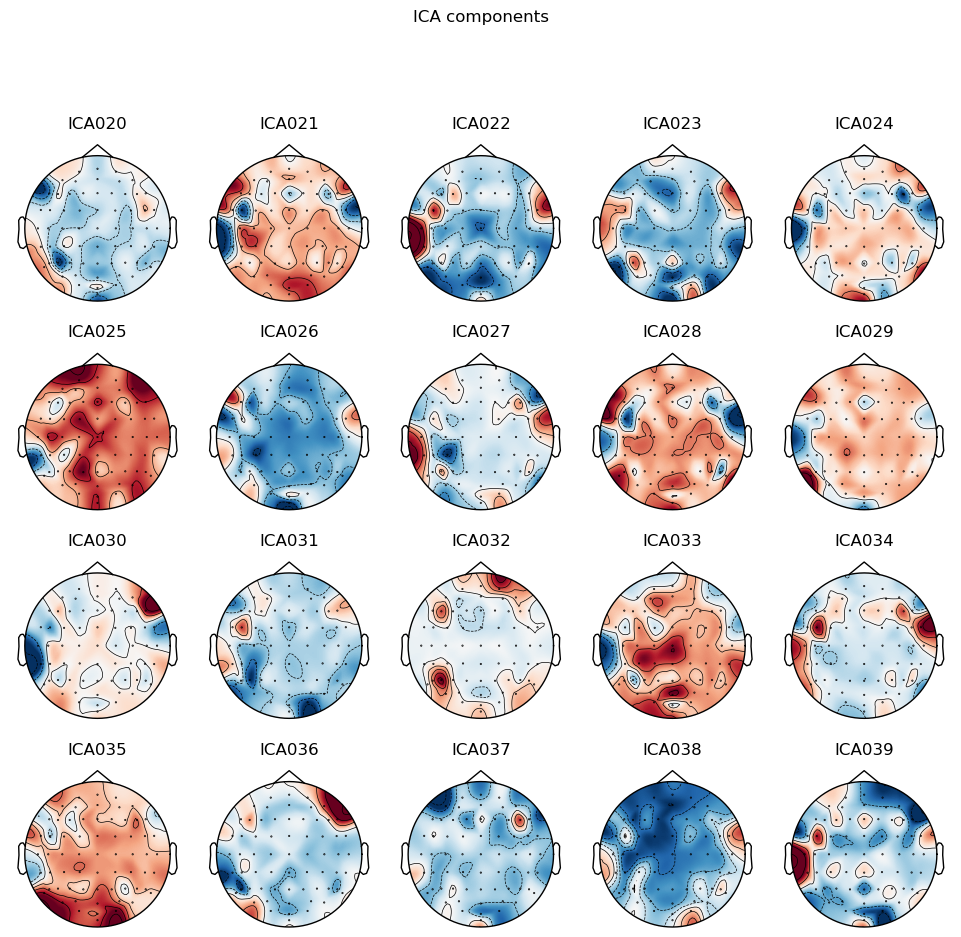

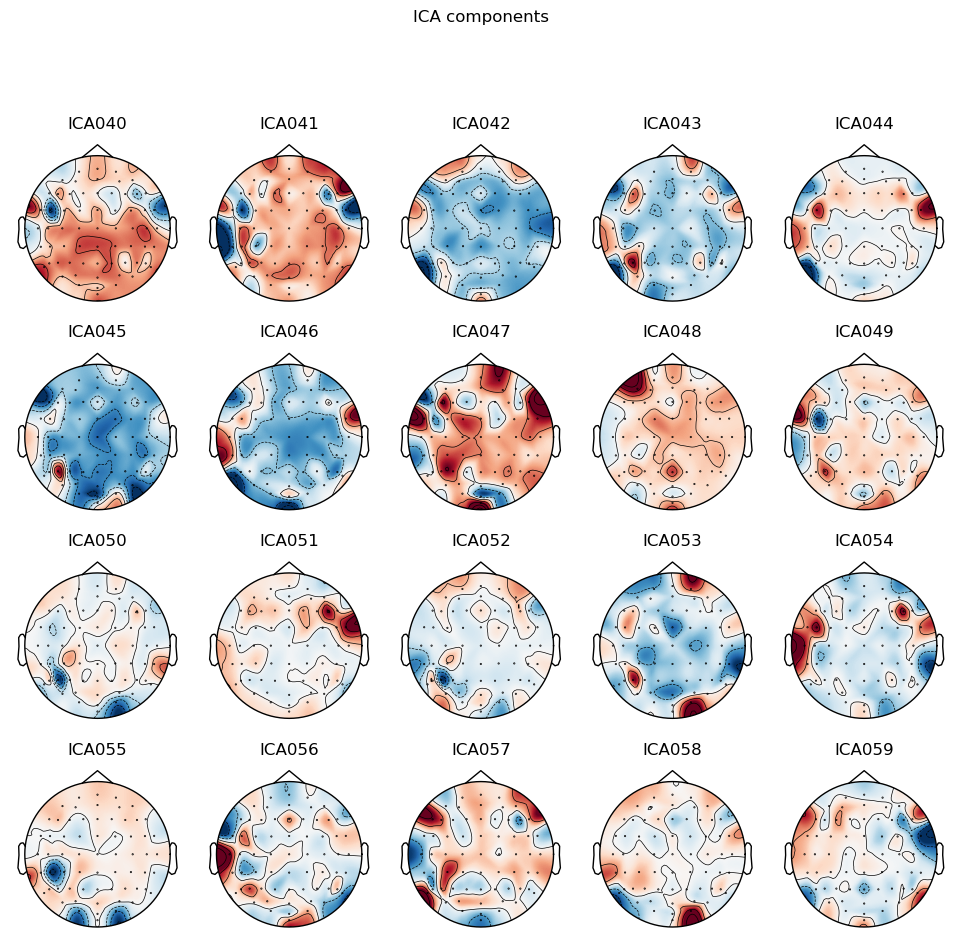

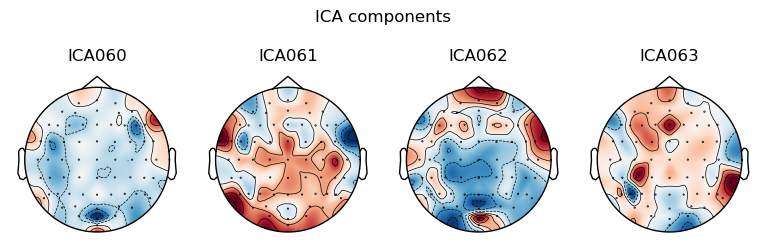

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [ ]:
ica.plot_components()

In [ ]:
ica.exclude = [8]
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<RawArray | 64 x 56320 (440.0 s), ~27.6 MB, data loaded>

## PLOTS

In [ ]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
t_inv = clean_triggers(events_arr[events_arr[:, 2]==3])
t_shinv = clean_triggers(events_arr[events_arr[:, 2]==4])
t_norm = clean_triggers(events_arr[events_arr[:, 2]==5])
t_modeswitch = np.concatenate([t_inv, t_shinv, t_norm])
t_modeswitch = events_inorder(t_modeswitch)

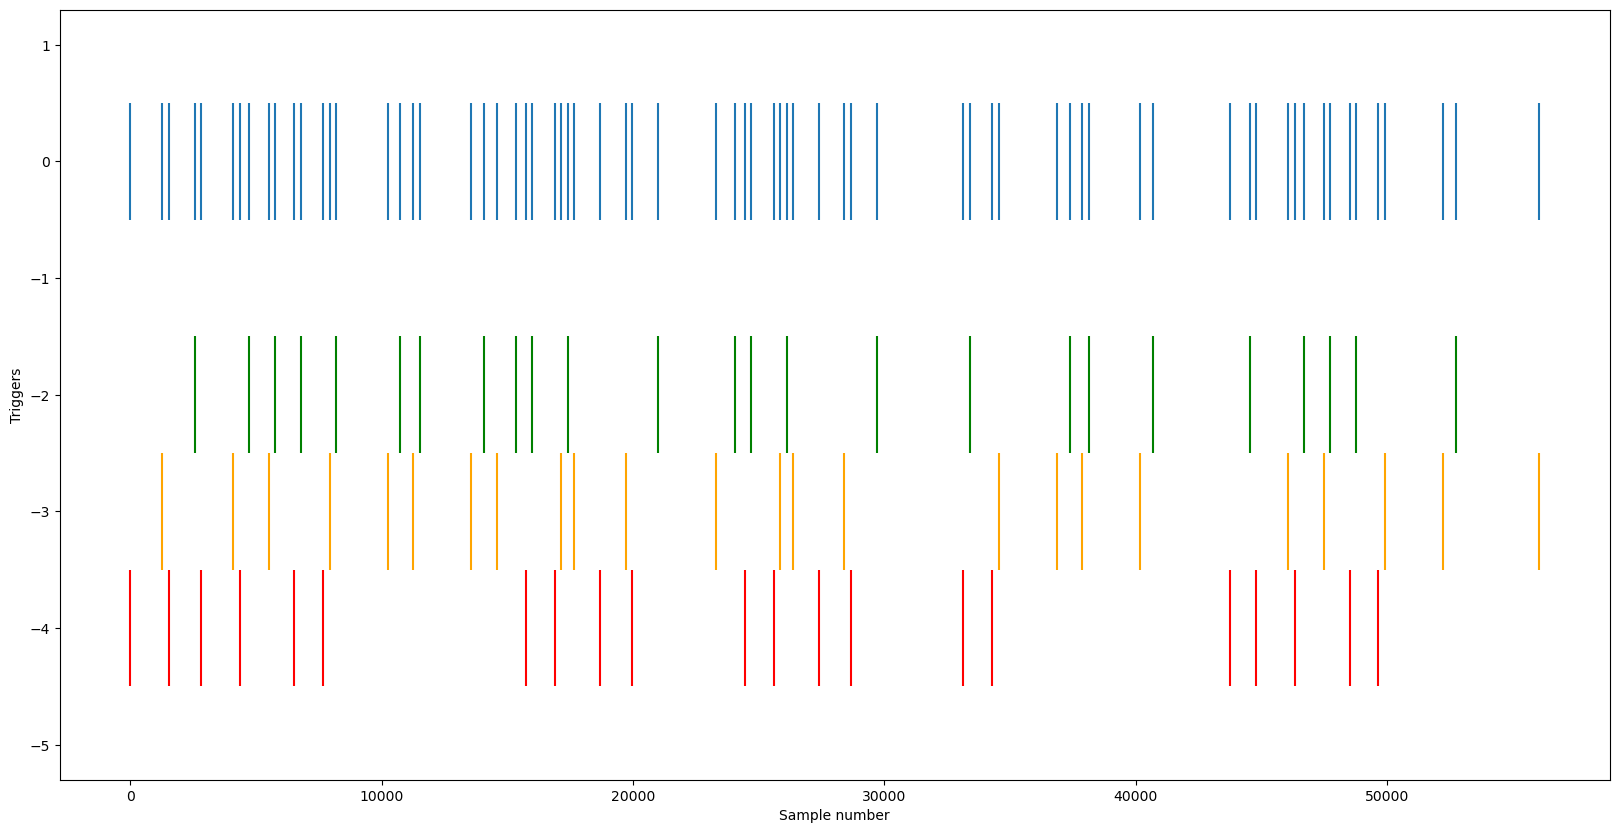

In [ ]:
plt.figure(figsize = (20,10))
plt.eventplot(t_modeswitch[:,0], lineoffsets = 0)
plt.eventplot(t_inv[:,0], color = 'green', lineoffsets = -2)
plt.eventplot(t_shinv[:,0], color = 'orange', lineoffsets = -3)
plt.eventplot(t_norm[:,0], color = 'red', lineoffsets=-4)

plt.xlabel('Sample number')
plt.ylabel('Triggers')
plt.show()

All keystroke ERPs

Not setting metadata
292 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 292 events and 129 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


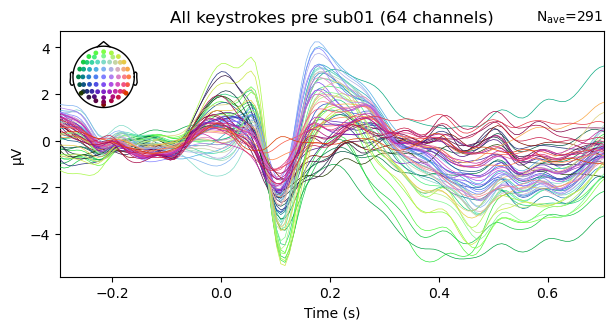

In [ ]:
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
fig = evoked.plot(titles = f'All keystrokes {period} sub{subject_ID}')
fig.savefig(f'{figure_folder}/{subject_ID}_error_{period}_all.png')

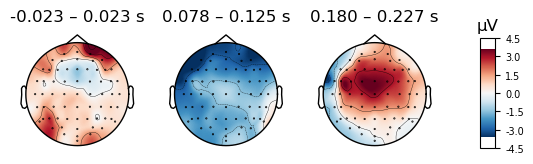

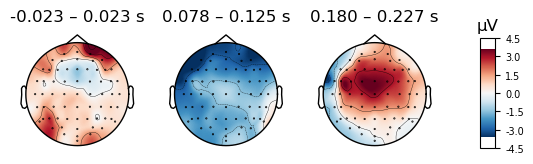

In [ ]:
evoked.plot_topomap(times=[0, 0.1, 0.2], average=0.05)

Not setting metadata
152 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 152 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


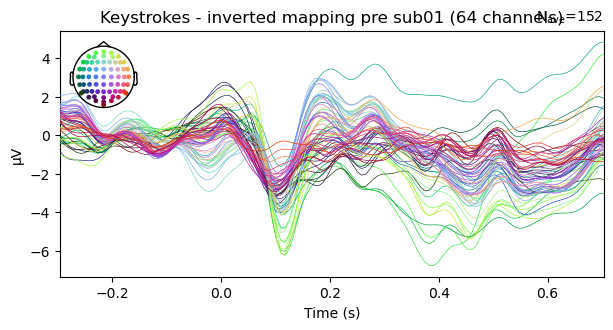

In [ ]:
inv_sections = find_sections(reconst_raw, t_inv, t_modeswitch)
inv_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, inv_sections)

epochs_inv = mne.Epochs(reconst_raw, inv_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
inv_evoked = epochs_inv.average()
fig = inv_evoked.plot(titles = f'Keystrokes - inverted mapping {period} sub{subject_ID}')

fig.savefig(f'{figure_folder}/{subject_ID}_error_{period}_inv.png')

Not setting metadata
73 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 73 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


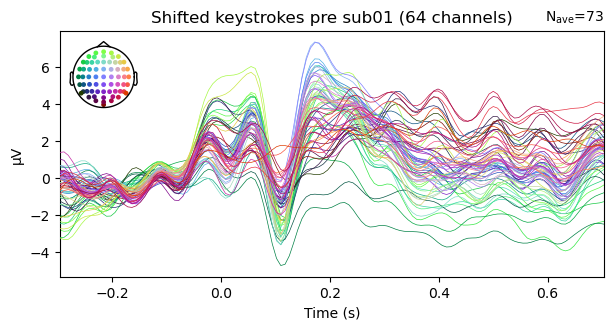

In [ ]:
shinv_sections = find_sections(reconst_raw, t_shinv, t_modeswitch)
shinv_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, shinv_sections)

epochs_shinv = mne.Epochs(reconst_raw, shinv_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
shinv_evoked = epochs_shinv.average()
fig = shinv_evoked.plot(titles = f'Shifted keystrokes {period} sub{subject_ID}')

fig.savefig(f'{figure_folder}/{subject_ID}_error_{period}_shinv.png')

Not setting metadata
67 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 67 events and 129 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


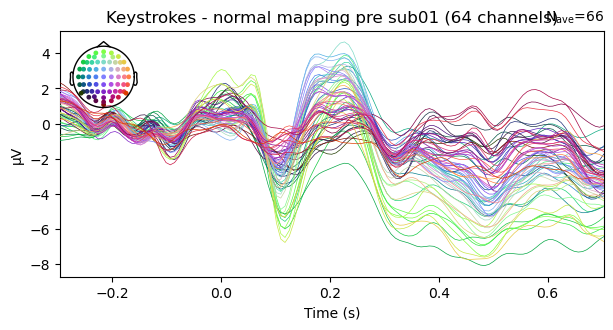

In [ ]:
norm_sections = find_sections(reconst_raw, t_norm, t_modeswitch)
norm_keystrokes = find_keystrokes(reconst_raw, t_keystrokes, norm_sections)

epochs_norm = mne.Epochs(reconst_raw, norm_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
norm_evoked = epochs_norm.average()
fig = norm_evoked.plot(titles = f'Keystrokes - normal mapping {period} sub{subject_ID}')

fig.savefig(f'{figure_folder}/{subject_ID}_error_{period}_norm.png')



In [ ]:
def plot_sections(section_list, downfreq = 128):
    plt.figure(figsize=(20,10))

    y1 = 0
    y2 = -1
    colors = ['green', 'orange', 'red']
    colour_idx = 0

    for sections in section_list:
        y = [y1, y1, y2, y2]
        sections = sections/downfreq 
        for i in range(sections.shape[0]):
            x = [sections[i][0], sections[i][1], sections[i][1], sections[i][0]]
            plt.fill(x, y, color=colors[colour_idx], alpha=0.2)
        colour_idx +=1
        y1 -=1
        y2-=1

    
    plt.xlabel('Time (s)', fontsize = 15)
    plt.ylabel('Playing mode', fontsize = 15)

    plt.savefig('playing_mode_time.png', dpi = 200)
    plt.show()

In [ ]:
inv_sections

array([[ 2559,  2815],
       [ 4736,  5503],
       [ 5759,  6527],
       [ 6783,  7679],
       [ 8191, 10239],
       [10751, 11263],
       [11519, 13567],
       [14079, 14591],
       [15359, 15743],
       [15999, 16895],
       [17407, 17663],
       [20991, 23295],
       [24063, 24447],
       [24703, 25599],
       [26111, 26367],
       [29695, 33150],
       [33406, 34303],
       [37374, 37886],
       [38142, 40190],
       [40702, 43774],
       [44542, 44798],
       [46718, 47486],
       [47742, 48510],
       [48766, 49662],
       [52734, 56062]])

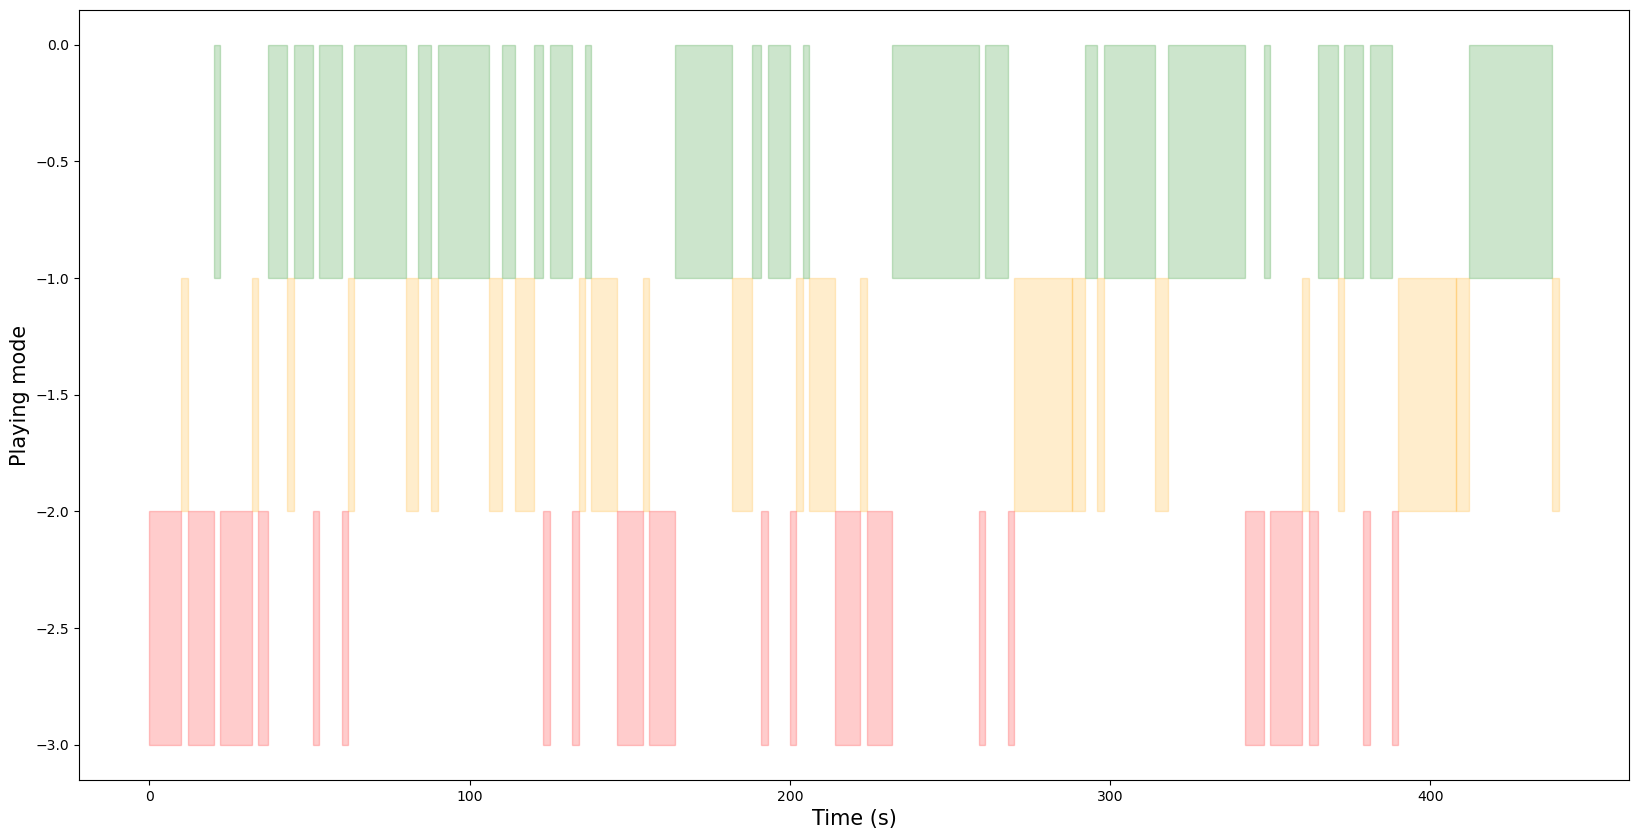

In [ ]:


all_sections = [
    inv_sections,
    shinv_sections,
    norm_sections
]
plot_sections(all_sections)


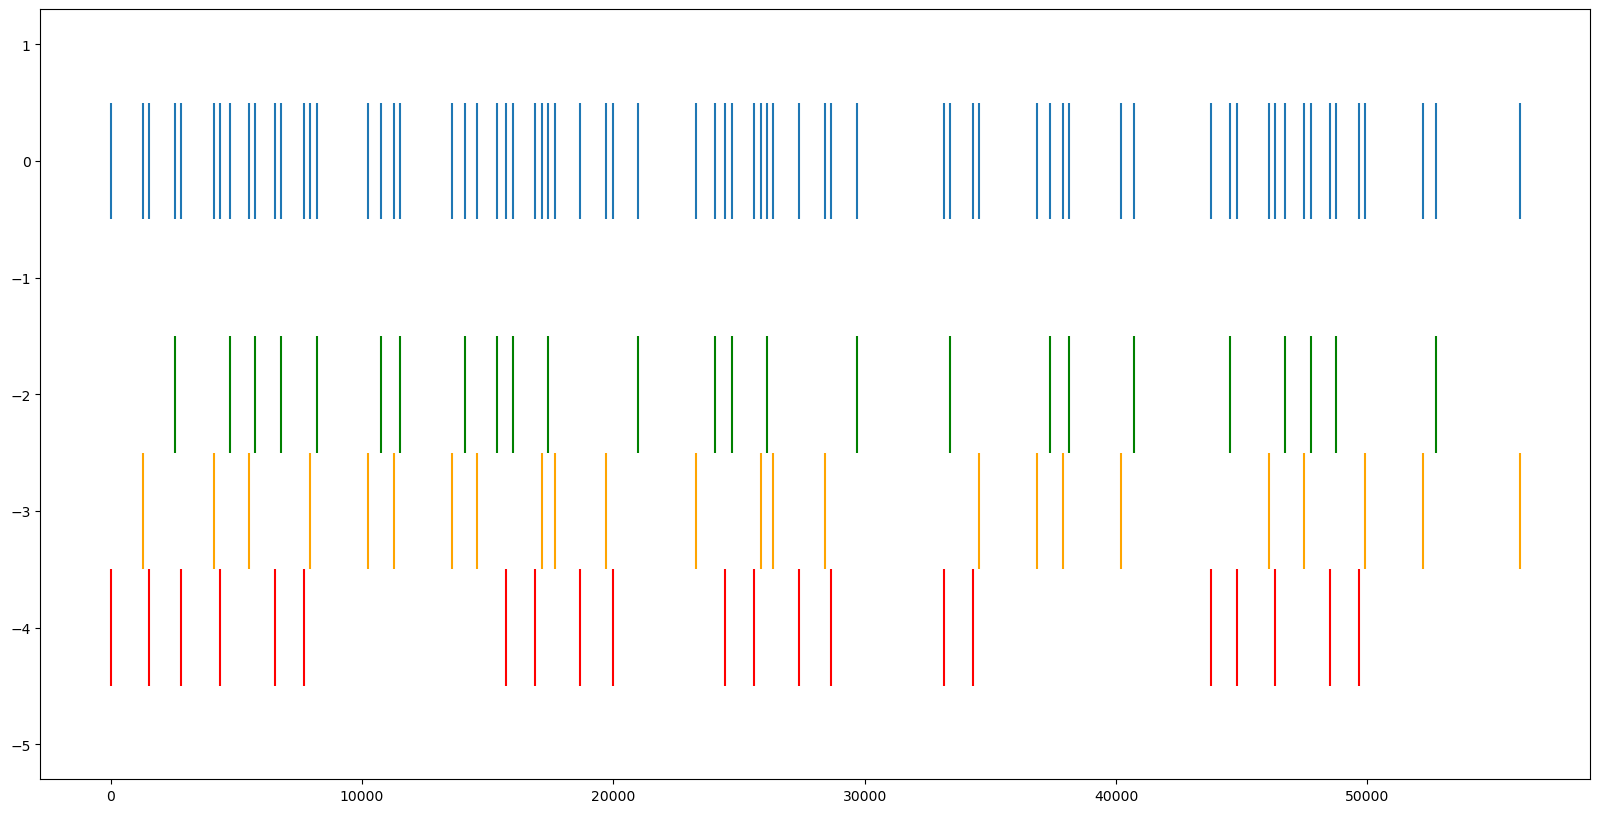

In [ ]:
plt.figure(figsize = (20,10))
plt.eventplot(t_modeswitch[:,0], lineoffsets = 0)
plt.eventplot(t_inv[:,0], color = 'green', lineoffsets = -2)
plt.eventplot(t_shinv[:,0], color = 'orange', lineoffsets = -3)
plt.eventplot(t_norm[:,0], color = 'red', lineoffsets=-4)
plt.show()